In [1]:
import time
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, SMOTEN)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours,
                                    RandomUnderSampler) 
from imblearn.combine import SMOTETomek, SMOTEENN

import shap

In [2]:
attrition_data = pd.read_csv('../data/attrition_features_ohe.csv')
attrition_data.head()

,Attrition,EnvironmentSatisfaction,Gender,JobLevel,JobSatisfaction,MonthlyIncome,OverTime,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,BusinessTravel_1,BusinessTravel_2,BusinessTravel_3,Age_Profile_1,Age_Profile_2,Age_Profile_3,Age_Profile_4
0,1,2,0,2,4,5993,1,0,1,6,1,0,0,0,1,0,0
1,0,3,1,2,2,5130,0,3,3,10,0,1,0,0,0,1,0
2,1,4,1,1,3,2090,1,3,3,0,1,0,0,0,1,0,0
3,0,4,0,1,3,2909,1,3,3,8,0,1,0,0,1,0,0
4,0,1,1,1,2,3468,0,3,3,2,1,0,0,0,1,0,0


## Data Splitting

In [3]:
X = attrition_data.drop(['Attrition'], axis=1)
y = attrition_data['Attrition']

In [4]:
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=42, test_size=0.30, stratify=y)

In [5]:
X_train.head()

,EnvironmentSatisfaction,Gender,JobLevel,JobSatisfaction,MonthlyIncome,OverTime,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,BusinessTravel_1,BusinessTravel_2,BusinessTravel_3,Age_Profile_1,Age_Profile_2,Age_Profile_3,Age_Profile_4
853,3,1,1,1,2552,0,4,3,1,1,0,0,1,0,0,0
435,2,1,3,3,13610,1,2,4,7,1,0,0,0,1,0,0
587,4,0,2,3,3149,0,3,3,5,1,0,0,0,0,1,0
1170,4,1,1,4,2580,0,0,2,4,0,1,0,0,1,0,0
159,3,0,1,3,2231,0,3,3,4,0,1,0,0,1,0,0


In [6]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {} # for plots/viz results
    results2 = {} # table results

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        # accuracy scores
        train_scores = []
        val_scores = []

        # recall scores
        train_recall = []
        val_recall = []
        
        # precision scores
        train_prec = []
        val_prec = []
        
        #f1 scores
        train_f1 = []
        val_f1 = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling to standardize values
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else: # else use raw data
                pass 

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            # precision
            train_prec.append(precision_score(y_train, train_preds))
            val_prec.append(precision_score(y_val, val_preds))
            
            # f1
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))
            
            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train Precision': np.round(np.mean(train_prec) * 100, 2),
                'Val Precision': np.round(np.mean(val_prec) * 100, 2),
                'Train F1 Score': np.round(np.mean(train_f1) * 100, 2),
                'Val F1 Score': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_prec)*100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_prec)*100, 2)),
                'Train F1 Score': '{:.2f}%'.format(np.round(np.mean(train_f1)*100, 2)),
                'Val F1 Score': '{:.2f}%'.format(np.round(np.mean(val_f1)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

In [7]:
# MODEL DICTIONARY
models_dict = {
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)
}

In [8]:
auto_run = auto_ml(X_train, y_train, models_dict, cv=StratifiedKFold(n_splits=5))

auto = auto_run[0]
auto_run[1] # table results

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.066669,92.64%,71.05%,97.15%,56.02%,85.72%,39.27%,63.50%,28.95%


# Sampling techniques

### Random Undersampling

In [9]:
res_list = [('RandomUnderSampler', RandomUnderSampler())
           ]

outputs_u = []
for title, res in res_list:
    print((title).center(120, "-"))
    var = auto_ml(X_train, y_train, models_dict,
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

---------------------------------------------------RandomUnderSampler---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.004530906677246094
Resampling done in 0.0016832351684570312
Resampling done in 0.0018031597137451172
Resampling done in 0.0014600753784179688
Resampling done in 0.001373291015625


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.033605,95.86%,95.78%,97.35%,94.28%,69.97%,40.34%,29.97%,62.64%


In [10]:
# Recall
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[0]['Val Recall']
ps_under['RandomUnderSampler Val Recall'] = outputs_u[0]['Val Recall']
ps_under

,NoResampling Val Recall,RandomUnderSampler Val Recall
GradientBoostingClassifier,28.95,62.64


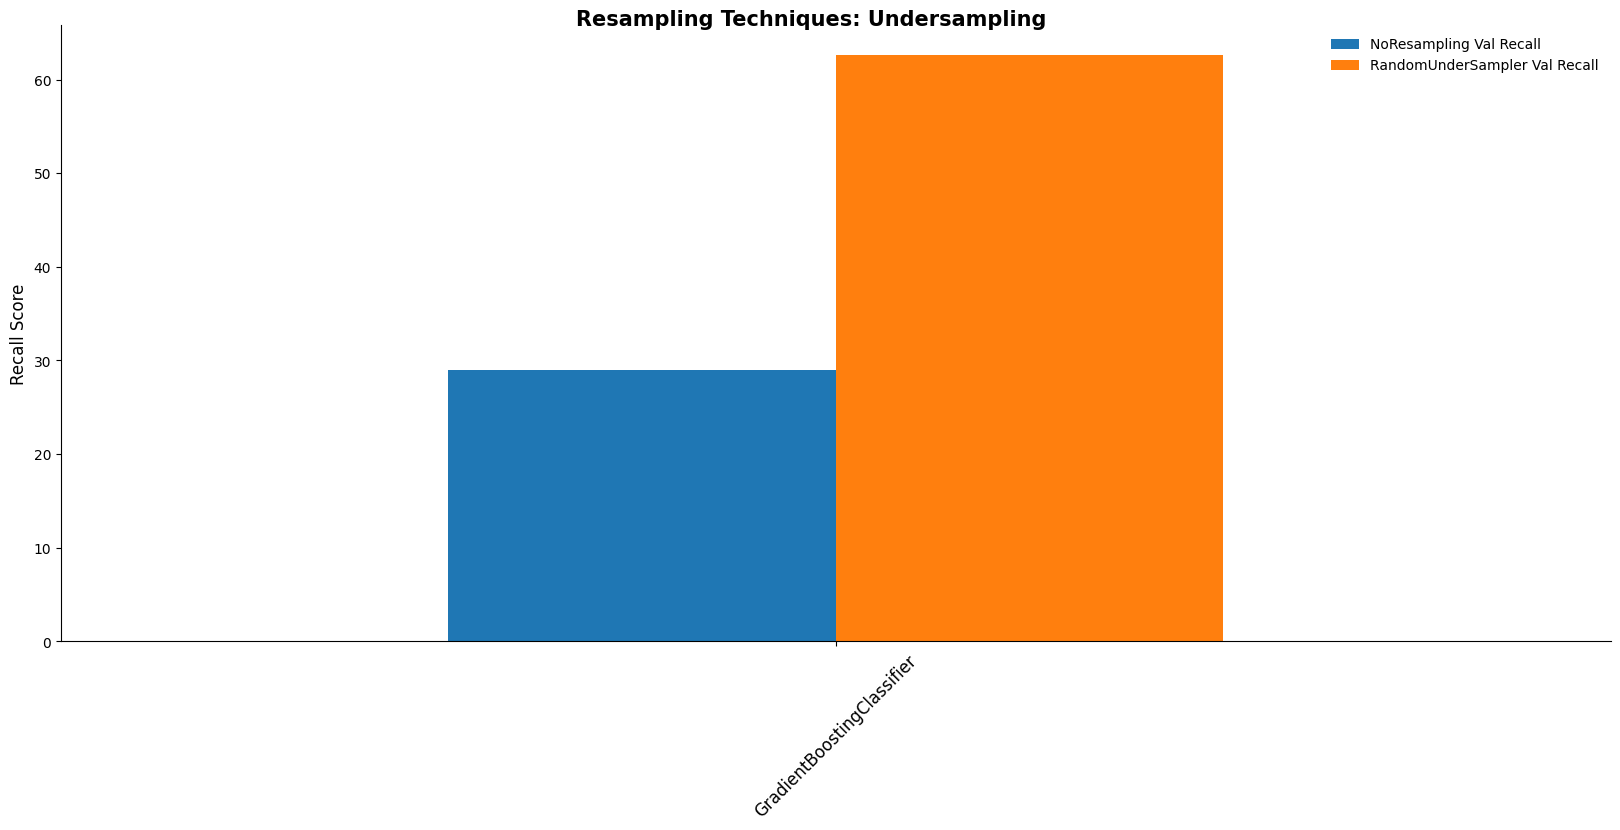

In [11]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques: Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [12]:
# Accuracy
ps_under_acc = pd.DataFrame(index=models_dict.keys())
ps_under_acc['NoResampling Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_under_acc['RandomUnderSampler Val Accuracy'] = outputs_u[0]['Val Accuracy']
ps_under_acc

,NoResampling Val Accuracy,RandomUnderSampler Val Accuracy
GradientBoostingClassifier,85.72,69.97


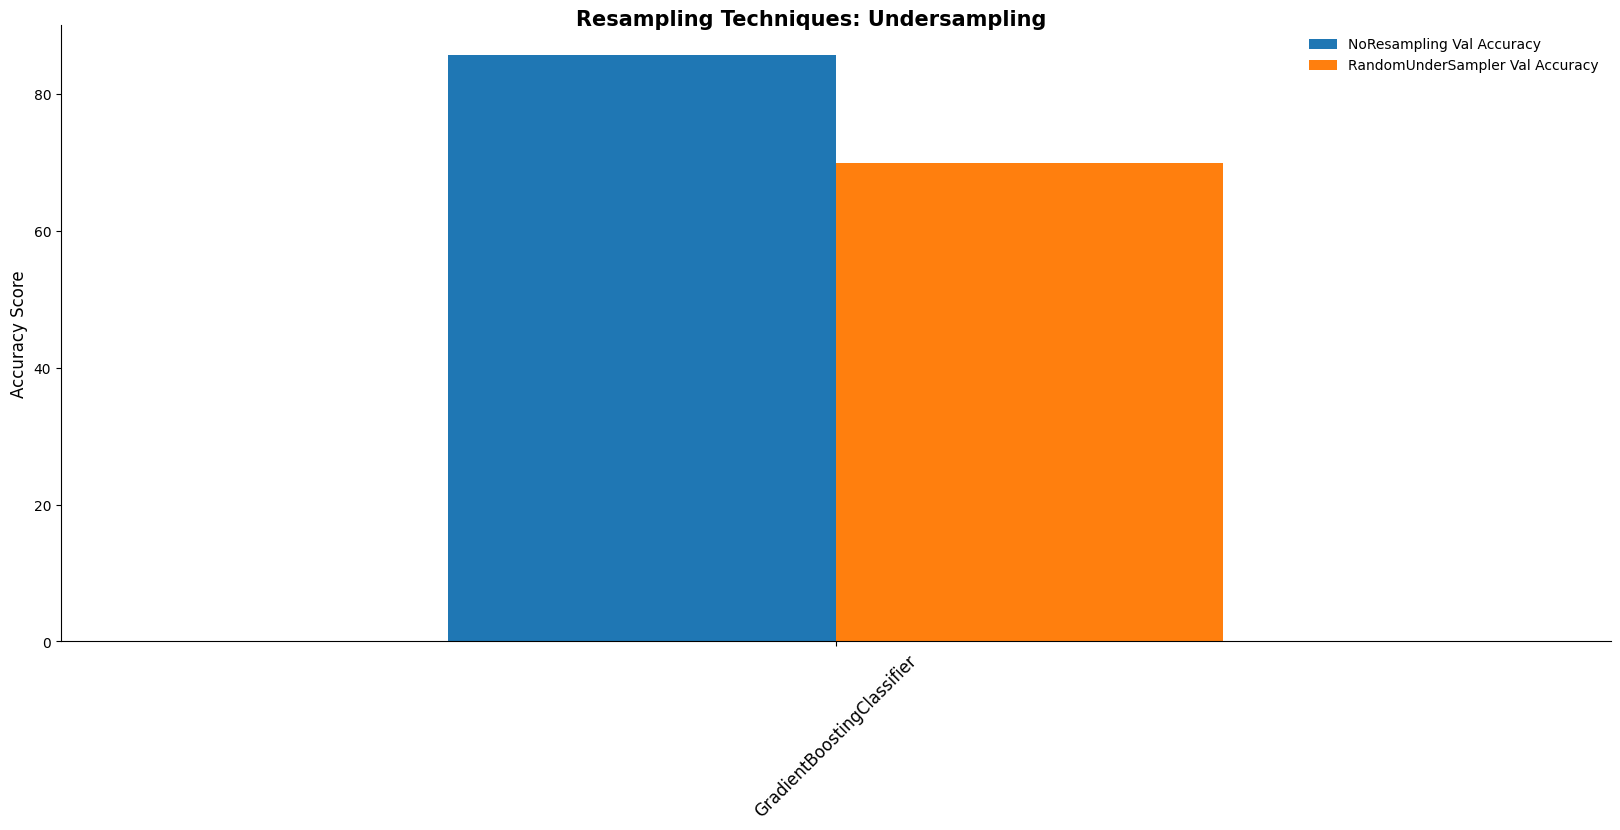

In [13]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques: Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [14]:
# Accuracy
ps_under_acc = pd.DataFrame(index=models_dict.keys())
ps_under_acc['NoResampling Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_under_acc['RandomUnderSampler Val Accuracy'] = outputs_u[0]['Val Accuracy']
ps_under_acc

,NoResampling Val Accuracy,RandomUnderSampler Val Accuracy
GradientBoostingClassifier,85.72,69.97


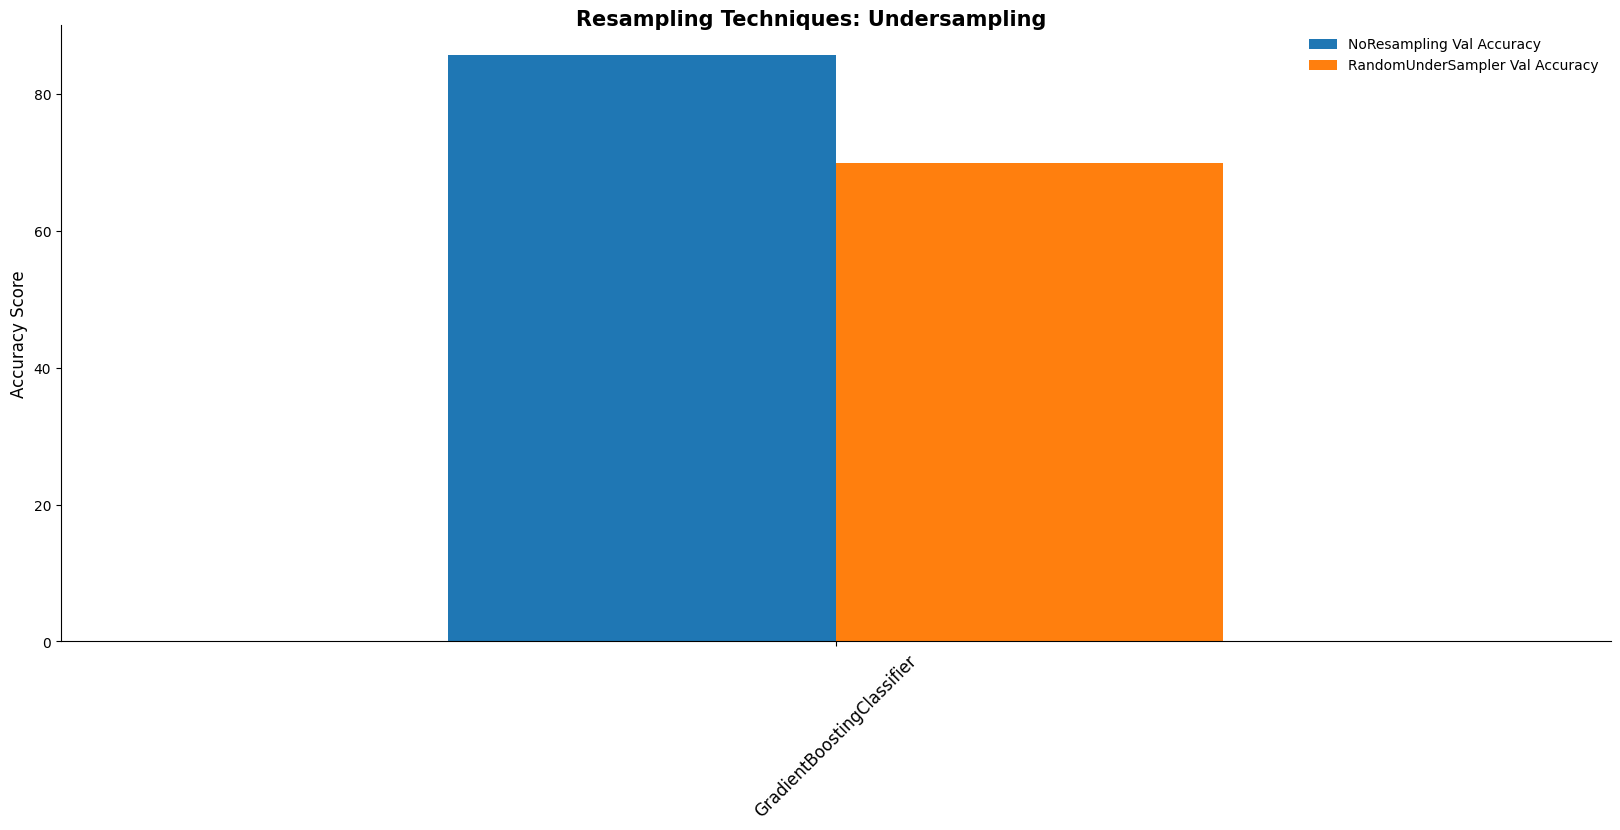

In [15]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques: Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

## TomekLinks and NearMiss

In [52]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss())]

outputs_u = []
for title, res in res_list:
    print((title).center(120, "-"))
    var = auto_ml(X_train, y_train, models_dict,
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

-------------------------------------------------------TomekLinks-------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.015942811965942383
Resampling done in 0.010987997055053711
Resampling done in 0.025770902633666992
Resampling done in 0.01147913932800293
Resampling done in 0.011747121810913086


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.064669,92.75%,74.70%,95.99%,61.14%,85.81%,44.12%,59.78%,35.56%


--------------------------------------------------------NearMiss--------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.007121086120605469
Resampling done in 0.003735780715942383
Resampling done in 0.003804922103881836
Resampling done in 0.006657838821411133
Resampling done in 0.003885030746459961


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.033756,97.66%,97.62%,99.38%,95.93%,38.97%,28.15%,17.39%,74.12%


In [53]:
# Recall
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[0]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']
ps_under

,NoResampling Val Recall,TomekLinks Val Recall,NearMiss Val Recall
GradientBoostingClassifier,28.95,35.56,74.12


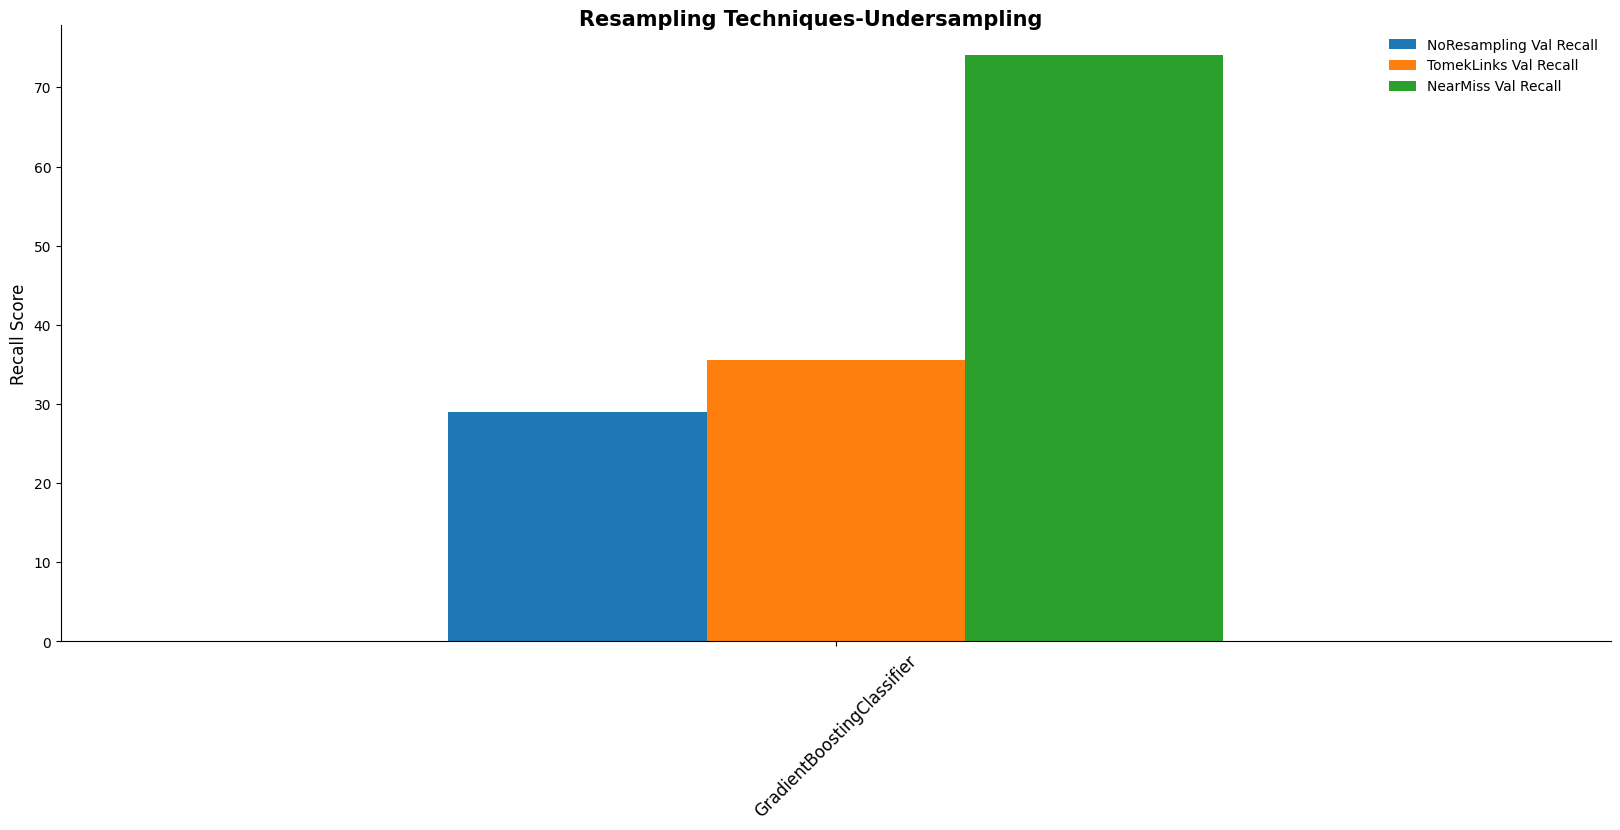

In [54]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [55]:
# Accuracy
ps_under_acc = pd.DataFrame(index=models_dict.keys())
ps_under_acc['NoResampling Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_under_acc['TomekLinks Val Accuracy'] = outputs_u[0]['Val Accuracy']
ps_under_acc['NearMiss Val Accuracy'] = outputs_u[1]['Val Accuracy']
ps_under_acc

,NoResampling Val Accuracy,TomekLinks Val Accuracy,NearMiss Val Accuracy
GradientBoostingClassifier,85.72,85.81,38.97


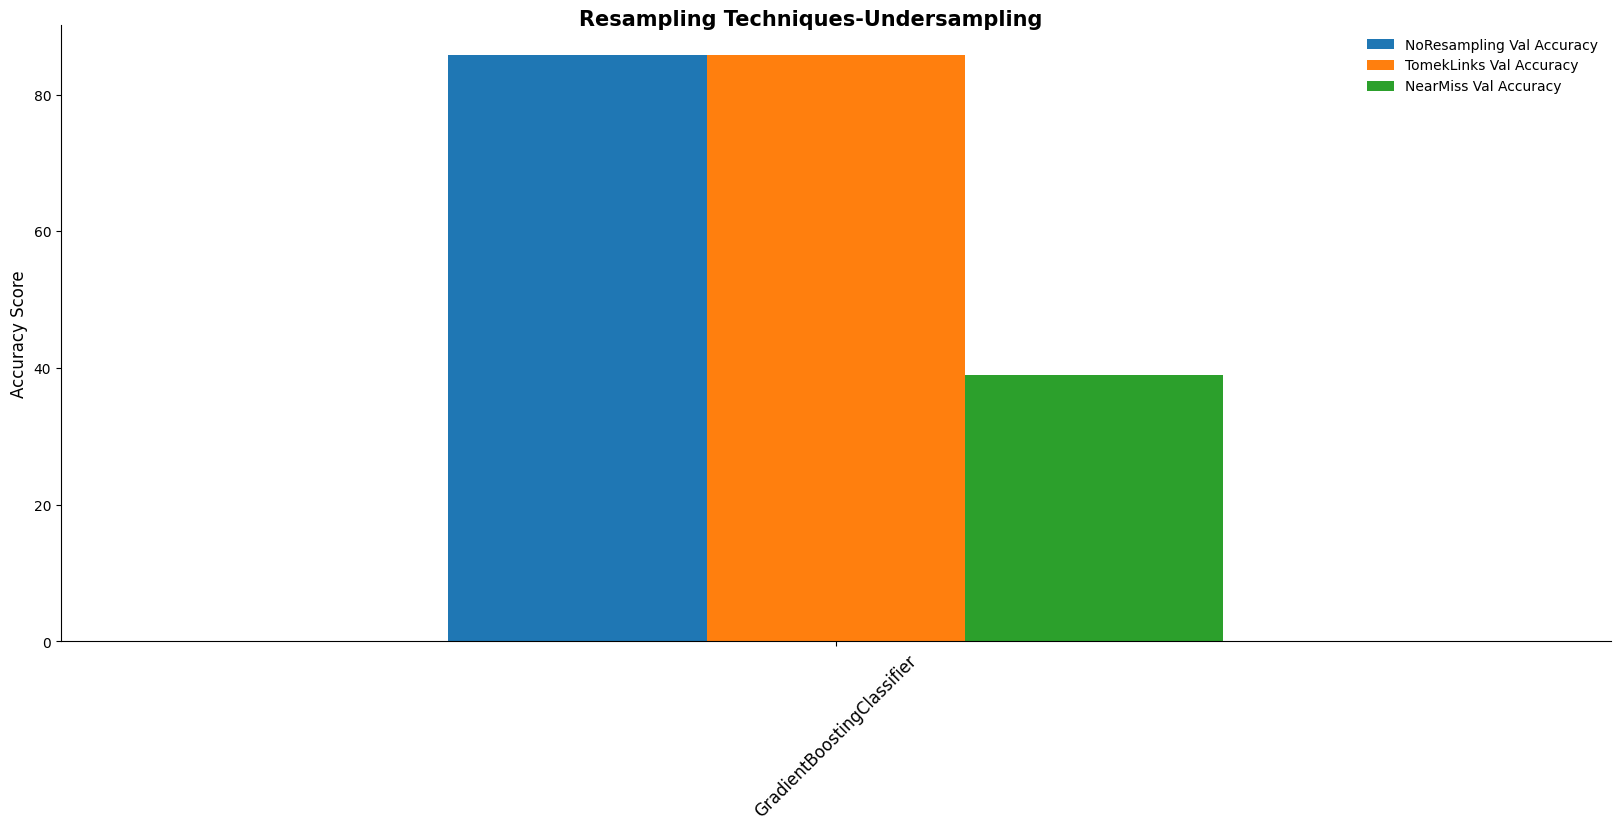

In [56]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

# Oversampling

## SMOTE and ADASYN

In [57]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print((title).center(120, "-"))
    var = auto_ml(X_train, y_train, models_dict, 
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------------SMOTE----------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.004029989242553711
Resampling done in 0.002635955810546875
Resampling done in 0.0023818016052246094
Resampling done in 0.0024170875549316406
Resampling done in 0.002716064453125


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.104577,92.16%,91.99%,94.07%,90.01%,82.31%,41.02%,44.35%,38.54%


---------------------------------------------------------ADASYN---------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.005739927291870117
Resampling done in 0.0071868896484375
Resampling done in 0.012728214263916016
Resampling done in 0.0044209957122802734
Resampling done in 0.020460844039916992


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.10198,91.79%,91.34%,94.04%,88.79%,81.83%,41.24%,43.35%,39.75%


In [58]:
# Accuracy
ps_over_acc = pd.DataFrame(index=models_dict.keys())
ps_over_acc['Baseline Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_over_acc['SMOTE Val Accuracy'] = outputs[0]['Val Accuracy']
ps_over_acc['ADASYN Val Accuracy'] = outputs[1]['Val Accuracy']
ps_over_acc

,Baseline Val Accuracy,SMOTE Val Accuracy,ADASYN Val Accuracy
GradientBoostingClassifier,85.72,82.31,81.83


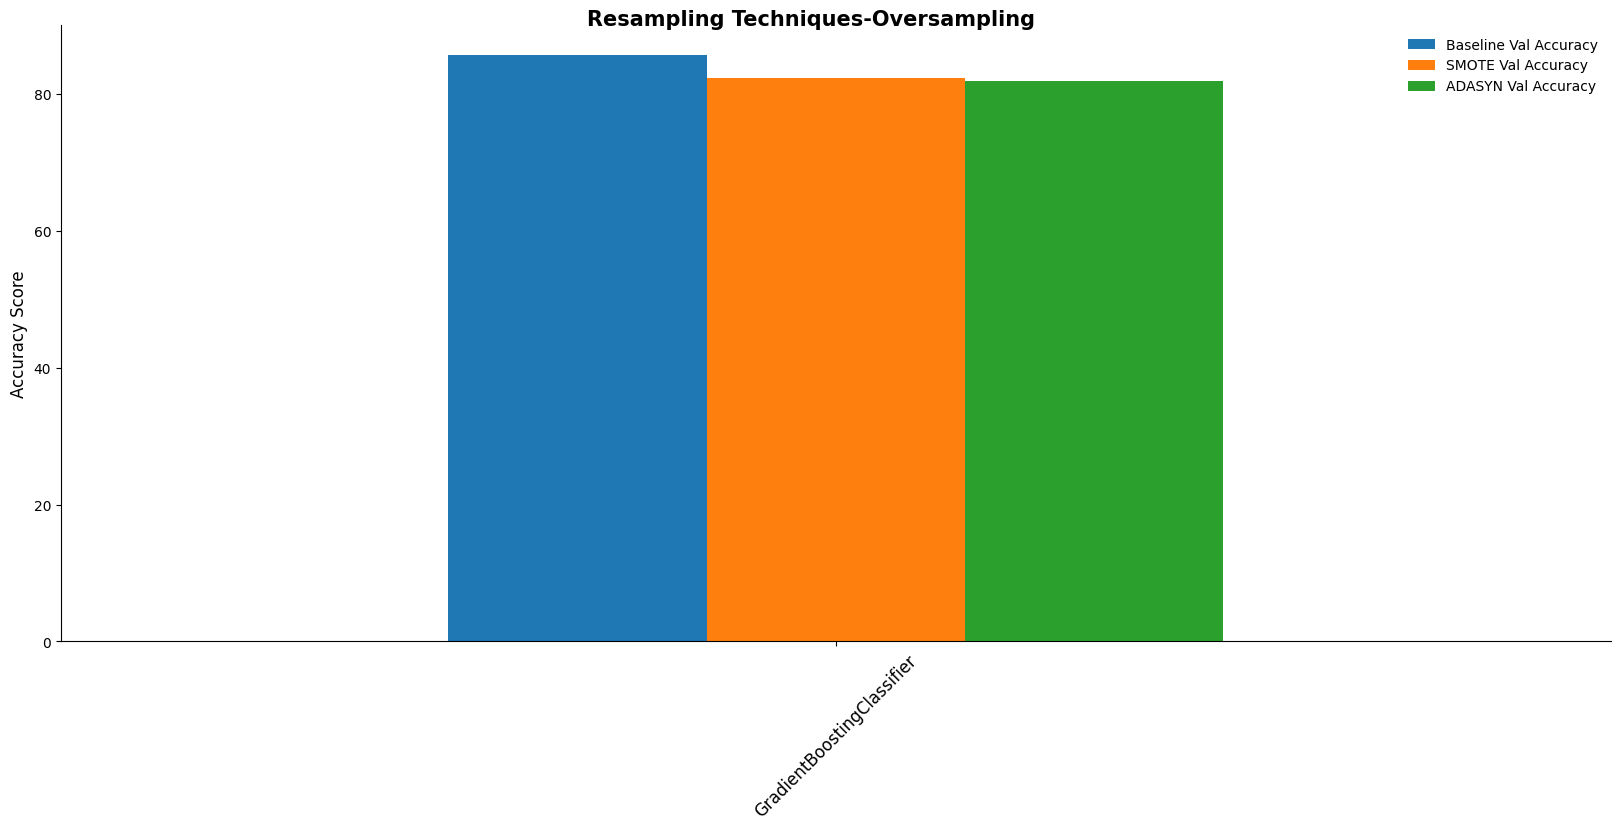

In [59]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [60]:
# Recall
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['Baseline Val Recall'] = auto_run[0]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
ps_over

,Baseline Val Recall,SMOTE Val Recall,ADASYN Val Recall
GradientBoostingClassifier,28.95,38.54,39.75


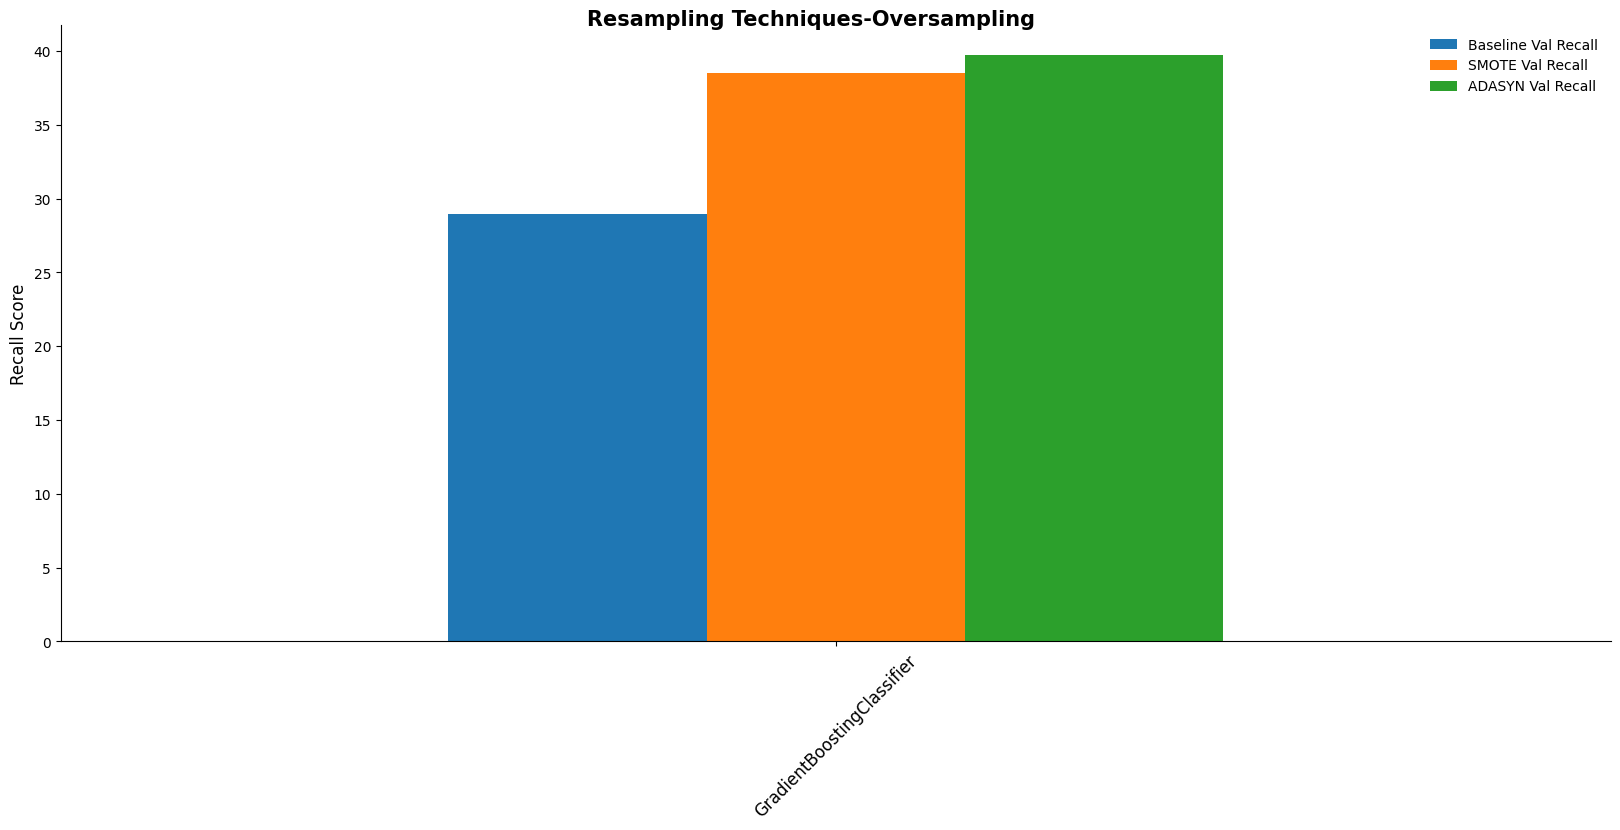

In [61]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

# SMOTEN

In [62]:
res_list = [('SMOTEN', SMOTEN())]

outputs = []
for title, res in res_list:
    print((title).center(120, "-"))
    var = auto_ml(X_train, y_train, models_dict, 
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------------SMOTEN---------------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.07921695709228516
Resampling done in 0.08270478248596191
Resampling done in 0.0734560489654541
Resampling done in 0.07451081275939941
Resampling done in 0.0721590518951416


,Run Time,Train Accuracy,Train F1 Score,Train Precision,Train Recall,Val Accuracy,Val F1 Score,Val Precision,Val Recall
GradientBoostingClassifier,0.094781,93.61%,93.51%,94.98%,92.09%,83.87%,41.78%,51.31%,36.17%


In [63]:
# Accuracy
ps_over_acc = pd.DataFrame(index=models_dict.keys())
ps_over_acc['Baseline Val Accuracy'] = auto_run[0]['Val Accuracy']
ps_over_acc['SMOTEN Val Accuracy'] = outputs[0]['Val Accuracy']
ps_over_acc

,Baseline Val Accuracy,SMOTEN Val Accuracy
GradientBoostingClassifier,85.72,83.87


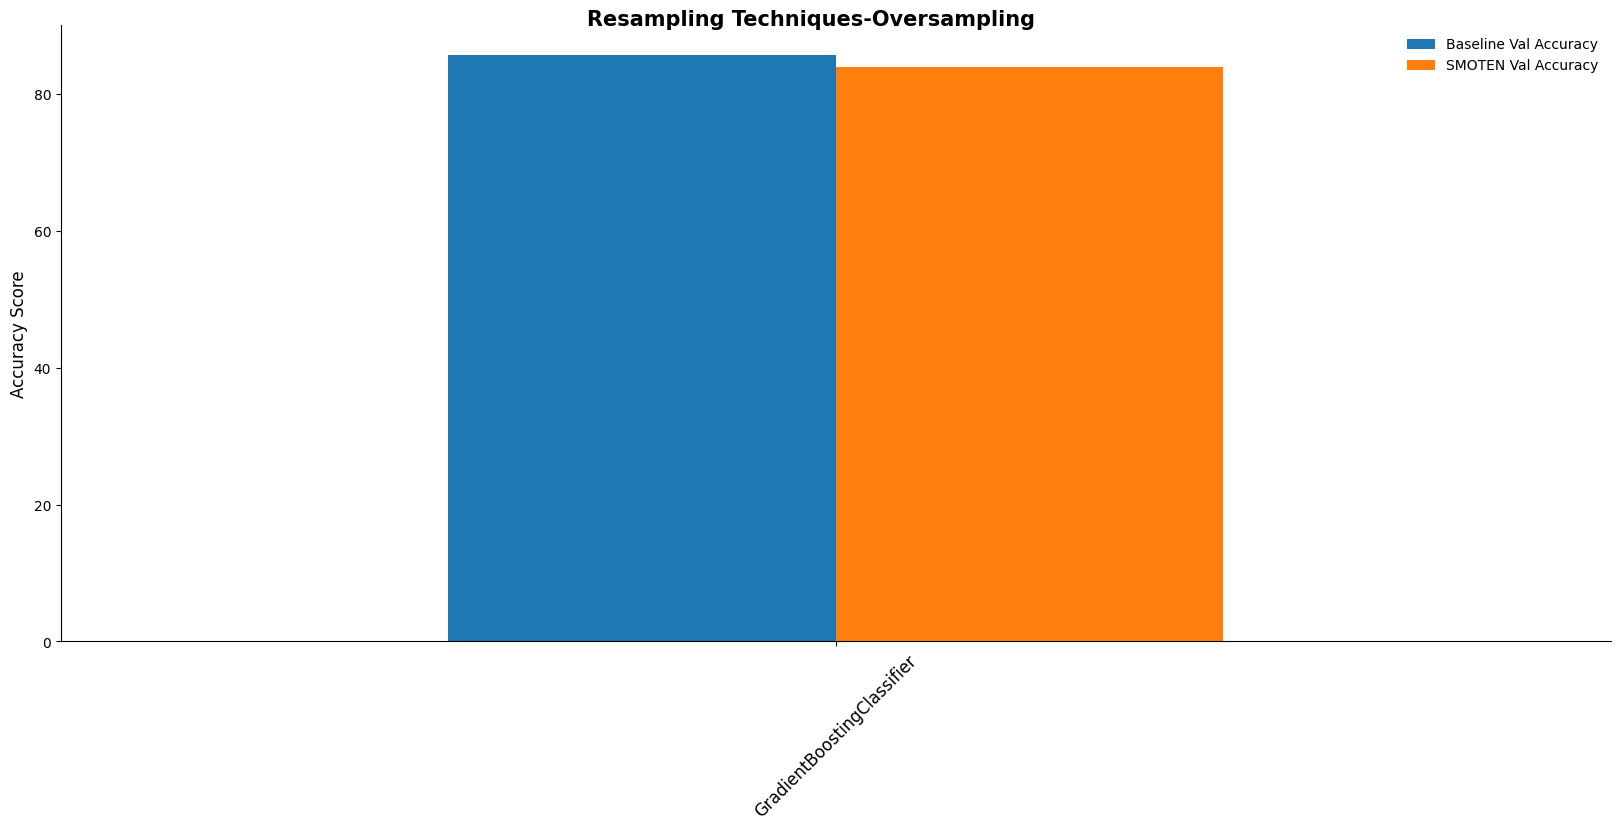

In [64]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over_acc.plot.bar(ax=ax)
ax.set_ylabel('Accuracy Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()


In [65]:
# Recall
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['Baseline Val Recall'] = auto_run[0]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over

,Baseline Val Recall,SMOTE Val Recall
GradientBoostingClassifier,28.95,36.17


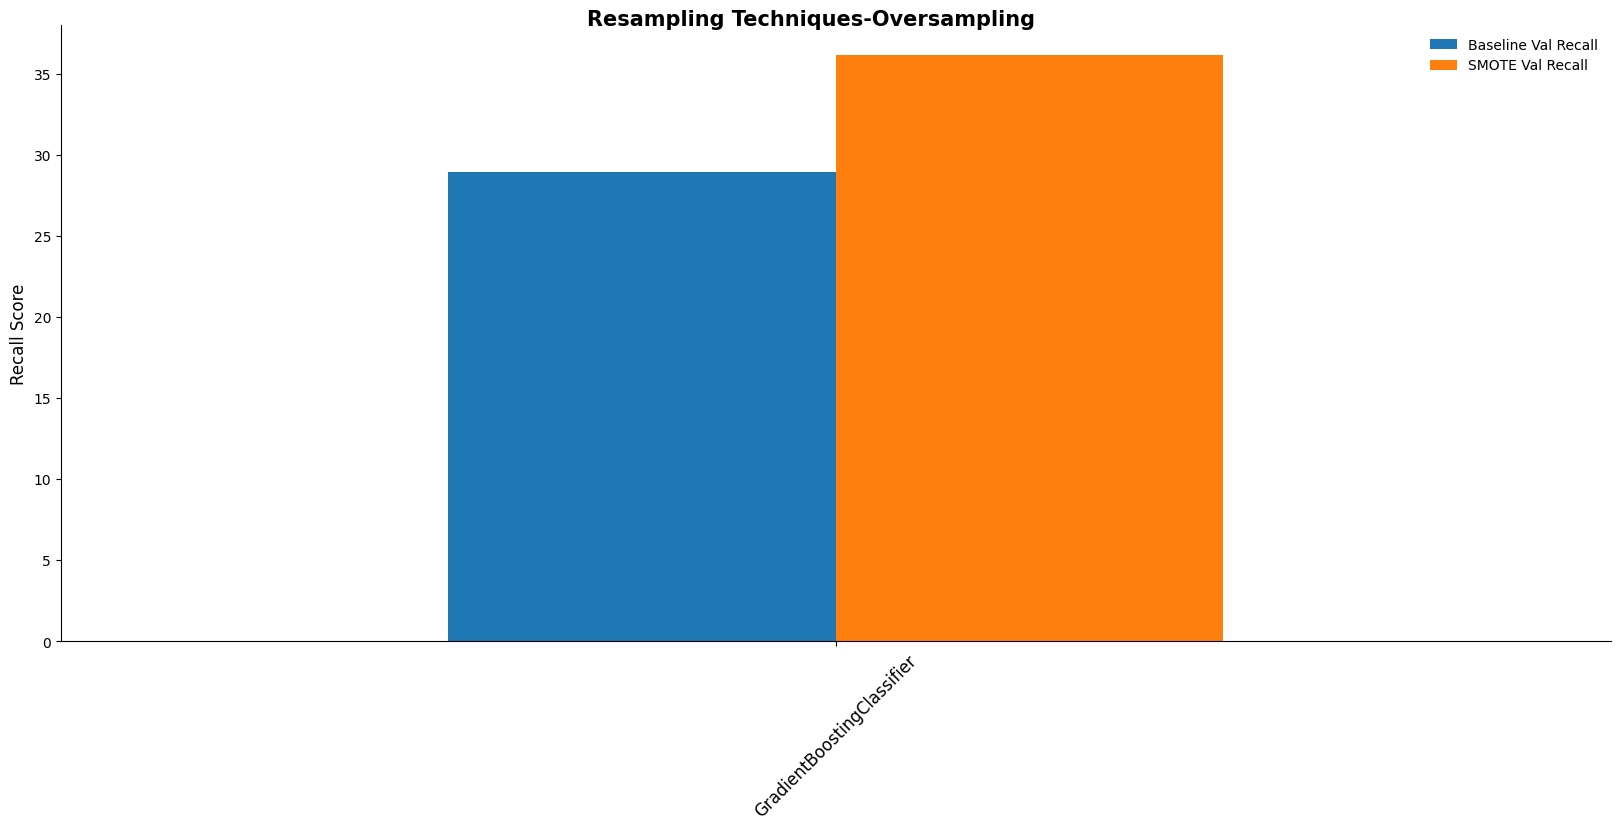

In [66]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

## Hypertuning

In [16]:
def train_gb(X, y, metric, res_t=None, hypertune=False, resample=False):
    params = {"n_estimators": [1, 10, 50, 100, 200],
              "learning_rate": [1, 0.5, 0.1, 0.01]
             }
    new_params = {'gradientboostingclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      GradientBoostingClassifier(random_state=143))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      GradientBoostingClassifier(random_state=143))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Gradient Boosting Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['Gradient Boosting Classifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

# Random Undersampling

In [17]:
start_time_gb = time.time()
gb_us_rec = train_gb(X_train, y_train, 'recall', RandomUnderSampler(),
                       hypertune=True, resample=True)
end_time_gb = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.707, test=0.606) total time=   0.0s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.632, test=0.697) total time=   0.0s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.684, test=0.697) total time=   0.0s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

[CV 1/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.842, test=0.485) total time=   0.0s
[CV 2/5; 7/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10
[CV 2/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.880, test=0.636) total time=   0.0s
[CV 3/5; 7/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10
[CV 3/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.902, test=0.758) total time=   0.0s
[CV 4/5; 7/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10
[CV 4/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.871, test=0.559) total time=   0.0s
[CV 5/5; 7/2

[CV 2/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.865, test=0.758) total time=   0.0s
[CV 3/5; 13/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50
[CV 3/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.857, test=0.636) total time=   0.0s
[CV 4/5; 13/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50
[CV 4/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.848, test=0.647) total time=   0.0s
[CV 5/5; 13/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50
[CV 5/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.865, test=0.667) total time=   0.0s
[CV 1

[CV 2/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.767, test=0.758) total time=   0.1s
[CV 3/5; 20/20] START gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200
[CV 3/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.820, test=0.667) total time=   0.1s
[CV 4/5; 20/20] START gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200
[CV 4/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.803, test=0.588) total time=   0.1s
[CV 5/5; 20/20] START gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200
[CV 5/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.812, test=0.576) total time

In [18]:
gb_us_rec

['Gradient Boosting Classifier',
 0.8414826839826839,
 0.6868092691622103,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 1, 'gradientboostingclassifier__n_estimators': 200}",
 2.523343086242676,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomundersampler', RandomUnderSampler()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(learning_rate=1, n_estimators=200,
                                             random_state=143))])]

In [19]:
start_time_gb1 = time.time()
gb_us_acc = train_gb(X_train, y_train, 'accuracy', RandomUnderSampler(),
                      hypertune=True, resample=True)
end_time_gb1 = time.time()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.832, test=0.791) total time=   0.0s
[CV 2/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.748, test=0.714) total time=   0.0s
[CV 3/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/20] END gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1;, score=(train=0.785, test=0.762) total time=   0.0s
[CV 4/5; 1/20] START gradientboostingclassifier__learning_rate=1, gradientboostingclassifier__n_estimators=1
[CV 4/5; 1/20] END gra

[CV 2/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.769, test=0.684) total time=   0.0s
[CV 3/5; 7/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10
[CV 3/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.770, test=0.689) total time=   0.0s
[CV 4/5; 7/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10
[CV 4/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.756, test=0.660) total time=   0.0s
[CV 5/5; 7/20] START gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10
[CV 5/5; 7/20] END gradientboostingclassifier__learning_rate=0.5, gradientboostingclassifier__n_estimators=10;, score=(train=0.739, test=0.654) total time=   0.0s
[CV 1/5; 8/2

[CV 3/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.765, test=0.714) total time=   0.0s
[CV 4/5; 13/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50
[CV 4/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.763, test=0.694) total time=   0.0s
[CV 5/5; 13/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50
[CV 5/5; 13/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=50;, score=(train=0.801, test=0.751) total time=   0.0s
[CV 1/5; 14/20] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=100
[CV 1/5; 14/20] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__n_estimators=100;, score=(train=0.764, test=0.728) total time=   0.0s
[CV

[CV 3/5; 19/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=100;, score=(train=0.747, test=0.689) total time=   0.0s
[CV 4/5; 19/20] START gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=100
[CV 4/5; 19/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=100;, score=(train=0.757, test=0.704) total time=   0.0s
[CV 5/5; 19/20] START gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=100
[CV 5/5; 19/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=100;, score=(train=0.801, test=0.771) total time=   0.0s
[CV 1/5; 20/20] START gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200
[CV 1/5; 20/20] END gradientboostingclassifier__learning_rate=0.01, gradientboostingclassifier__n_estimators=200;, score=(train=0.753, test=0.757) total time

In [20]:
gb_us_acc

['Gradient Boosting Classifier',
 0.7594358196982388,
 0.7638219275396638,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__n_estimators': 1}",
 2.4266891479492188,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                 ('randomundersampler', RandomUnderSampler()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(learning_rate=0.01, n_estimators=1,
                                             random_state=143))])]

In [21]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [gb_us_rec[0],
                np.round(gb_us_acc[1]*100, 6),
                np.round(gb_us_acc[2]*100, 6),
                np.round(gb_us_rec[1]*100, 6),
                np.round(gb_us_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [gb_us_rec[0],
                 '{:.2f}%'.format(np.round(gb_us_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Gradient Boosting Classifier,75.94%,76.38%,84.15%,68.68%


In [22]:
rh = gb_us_rec[-1]
rh.fit(X_train, y_train)
y_preds = rh.predict(X_test)
rh_holdout_score = recall_score(y_test, y_preds)

In [23]:
base_var = train_gb(X_train, y_train, 'recall', hypertune=False, resample=False)

base_model = base_var[-1]
base_model.fit(X_train, y_train)
y_preds = base_model.predict(X_test)
holdout_score = recall_score(y_test, y_preds)

In [24]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(gb_us_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_us_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,56.02%,28.95%,26.76%
Resampling x Hypertune,84.15%,68.68%,74.65%


# NearMiss

In [ ]:
start_time_gb = time.time()
gb_tk_rec = train_gb(X_train, y_train, 'recall', NearMiss(),
                       hypertune=True, resample=True)
end_time_gb = time.time()

In [ ]:
gb_tk_rec

In [ ]:
start_time_gb1 = time.time()
gb_tk_acc = train_gb(X_train, y_train, 'accuracy', NearMiss(),
                      hypertune=True, resample=True)
end_time_gb1 = time.time()

In [ ]:
gb_tk_acc

In [ ]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [gb_tk_rec[0],
                np.round(gb_tk_acc[1]*100, 6),
                np.round(gb_tk_acc[2]*100, 6),
                np.round(gb_tk_rec[1]*100, 6),
                np.round(gb_tk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [gb_tk_rec[0],
                 '{:.2f}%'.format(np.round(gb_tk_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_rec[2]*100, 2))]
hyper2.style.hide_index()

In [ ]:
rh = gb_tk_rec[-1]
rh.fit(X_train, y_train)
y_preds = rh.predict(X_test)
rh_holdout_score = recall_score(y_test, y_preds)

In [ ]:
base_var = train_gb(X_train, y_train, 'recall', hypertune=False, resample=False)

base_model = base_var[-1]
base_model.fit(X_train, y_train)
y_preds = base_model.predict(X_test)
holdout_score = recall_score(y_test, y_preds)

In [ ]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(gb_tk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_tk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

## ADASYN

In [ ]:
start_time_gb = time.time()
gb_ad_rec = train_gb(X_train, y_train, 'recall', ADASYN(),
                       hypertune=True, resample=True)
end_time_gb = time.time()

In [ ]:
gb_ad_rec

In [ ]:
start_time_gb = time.time()
gb_ad_acc = train_gb(X_train, y_train, 'recall', ADASYN(),
                       hypertune=True, resample=True)
end_time_gb = time.time()

In [ ]:
gb_ad_acc

In [ ]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [gb_ad_rec[0],
                np.round(gb_ad_acc[1]*100, 6),
                np.round(gb_ad_acc[2]*100, 6),
                np.round(gb_ad_rec[1]*100, 6),
                np.round(gb_ad_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [gb_tk_rec[0],
                 '{:.2f}%'.format(np.round(gb_ad_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_ad_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_ad_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_ad_rec[2]*100, 2))]
hyper2.style.hide_index()

In [ ]:
rh = gb_ad_rec[-1]
rh.fit(X_train, y_train)
y_preds = rh.predict(X_test)
rh_holdout_score = recall_score(y_test, y_preds)

In [ ]:
base_var = train_gb(X_train, y_train, 'recall', hypertune=False, resample=False)

base_model = base_var[-1]
base_model.fit(X_train, y_train)
y_preds = base_model.predict(X_test)
holdout_score = recall_score(y_test, y_preds)

In [ ]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(gb_ad_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_ad_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

## SMOTEN

In [ ]:
start_time_sm = time.time()
gb_sm_rec = train_gb(X_train, y_train, 'recall', SMOTEN(),
                       hypertune=True, resample=True)
end_time_sm = time.time()

In [ ]:
gb_sm_rec

In [ ]:
start_time_sm1 = time.time()
gb_sm_acc = train_gb(X_train, y_train, 'accuracy', SMOTEN(),
                      hypertune=True, resample=True)
end_time_sm1 = time.time()

In [ ]:
gb_sm_acc

In [ ]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper3 = pd.DataFrame(columns=cols)
hyper3.loc[0] = [gb_sm_rec[0],
                np.round(gb_sm_acc[1]*100, 6),
                np.round(gb_sm_acc[2]*100, 6),
                np.round(gb_sm_acc[1]*100, 6),
                np.round(gb_sm_acc[2]*100, 6)]
hyper4 = pd.DataFrame(columns=cols)
hyper4.loc[0] = [gb_sm_rec[0],
                 '{:.2f}%'.format(np.round(gb_sm_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_sm_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_sm_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_sm_acc[2]*100, 2))]
hyper4.style.hide_index()

In [ ]:
# re-fitting for the holdout
rh = gb_sm_rec[-1]
rh.fit(X_train, y_train)
y_preds1 = rh.predict(X_test)
rh_holdout_score1 = recall_score(y_test, y_preds1)

In [ ]:
# cross-validation
base_var = train_gb(X_train, y_train, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_train, y_train)
y_preds1 = base_model.predict(X_test)
holdout_score = recall_score(y_test, y_preds1)

In [ ]:
summary1.shape

In [ ]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(gb_sm_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(gb_sm_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score1*100, 2))]
summary.style.hide_index()

In [25]:
# SAVE MODEL
model = rh['gradientboostingclassifier']
pickle.dump(model, open('../model/model_gbm.pkl', 'wb'))

In [26]:
# training_data=pd.DataFrame(X_train.columns)
# training_data
# training_data.to_csv('../model/training_cols.csv', index=False)

# Model Explainability

## Feature Importance

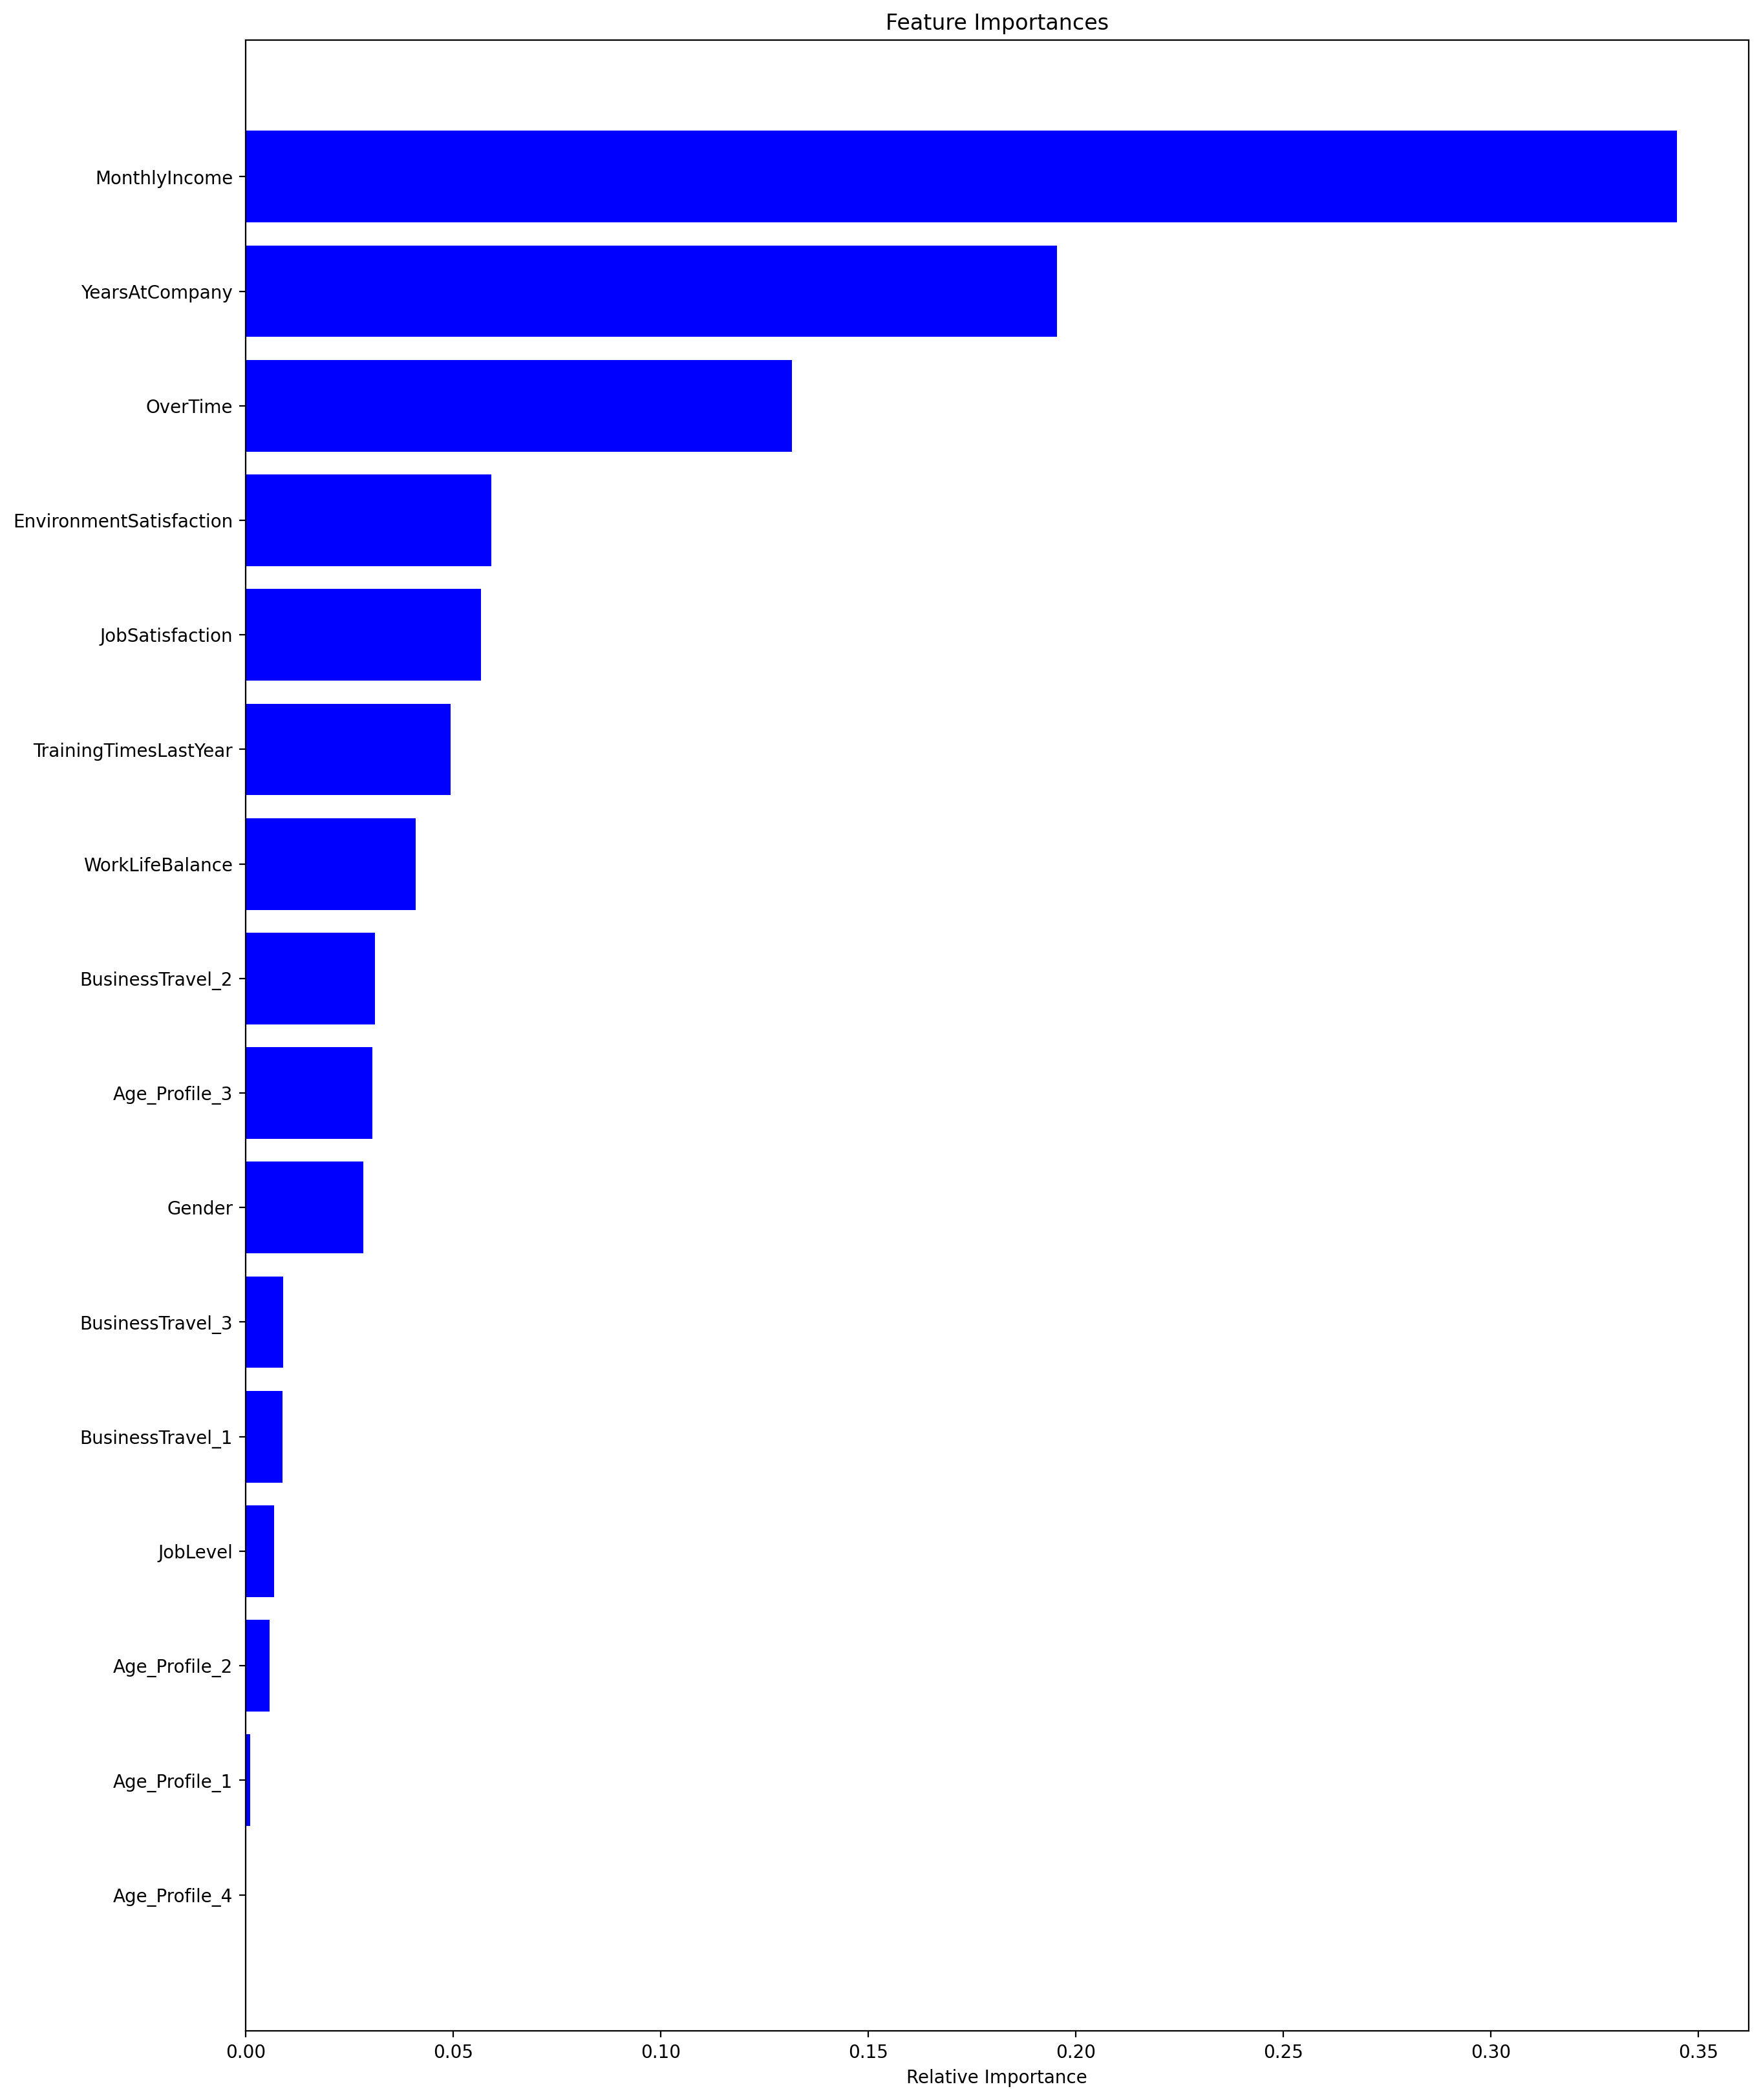

In [27]:
fig, ax = plt.subplots(figsize=(15, 20), dpi=200)

# print(model.feature_importances_)
importances = model.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### SHAP

In [28]:
ex = shap.KernelExplainer(model.predict, shap.sample(X_train,100))

  0%|          | 0/441 [00:00<?, ?it/s]

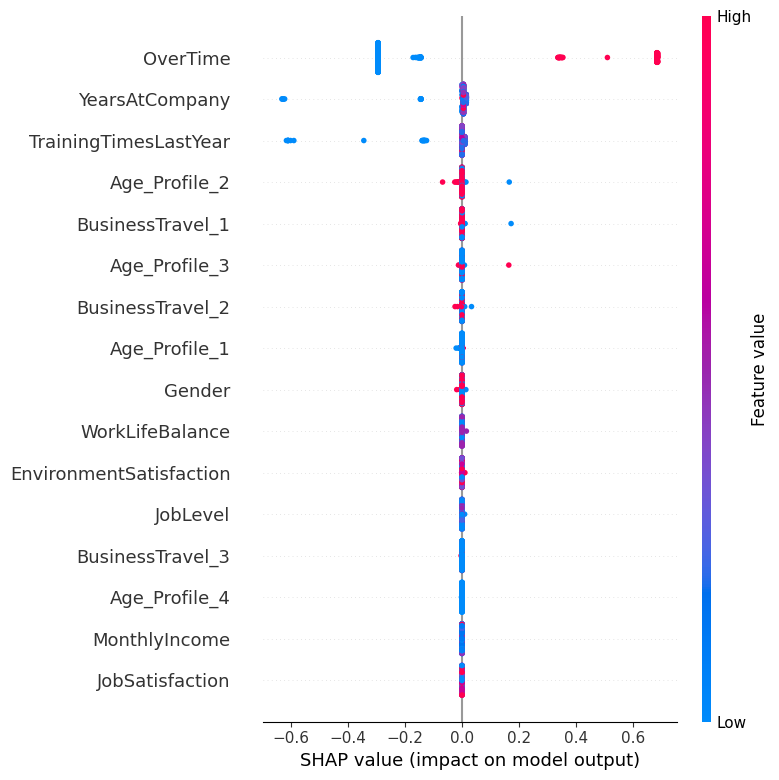

In [29]:
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [30]:
shap.initjs()

model = rh['gradientboostingclassifier']
explainer = shap.TreeExplainer(model, feature_names=X_test.columns)
shap_values = explainer.shap_values(X_test.iloc[0,:])
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[0,:])

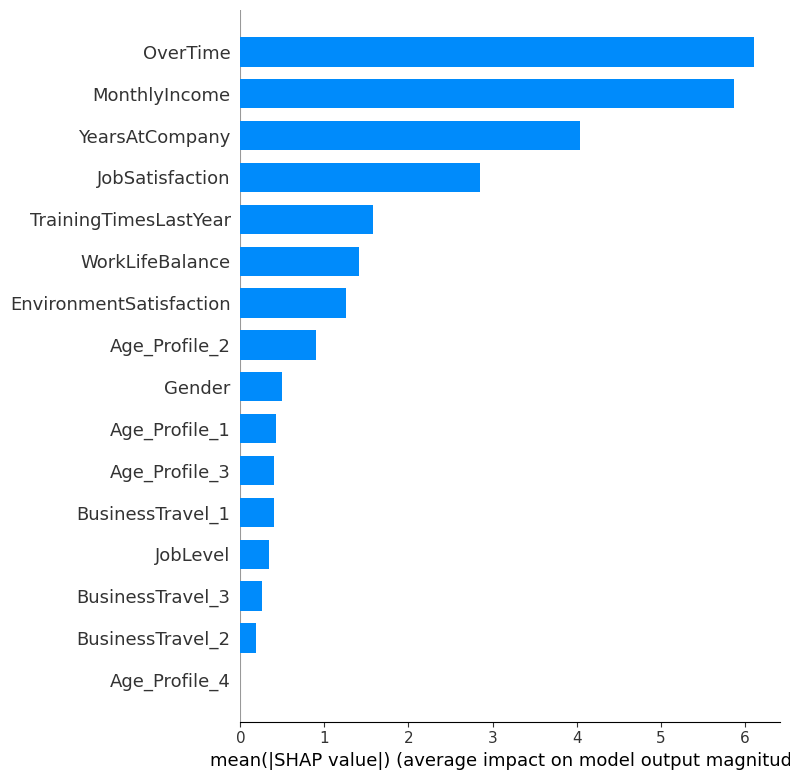

In [31]:
shap.initjs()

model = rh['gradientboostingclassifier']
explainer = shap.TreeExplainer(model, feature_names=X_test.columns)
shap_values = explainer.shap_values(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test.columns, plot_type='bar')

  0%|          | 0/441 [00:00<?, ?it/s]

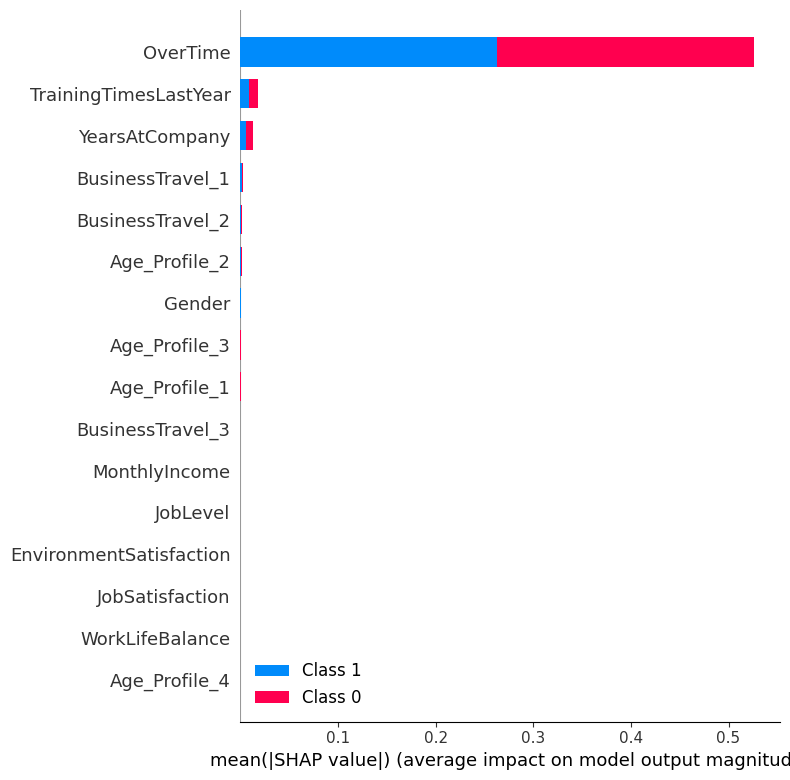

In [32]:
shap.initjs()

model = rh['gradientboostingclassifier']
background_data = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(model.predict_proba, background_data)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

### Beeswarm

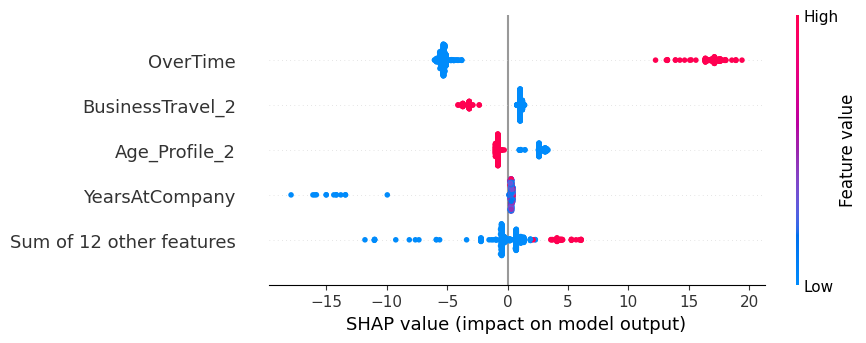

In [33]:
explainer1 = shap.Explainer(model, X_test)
shap_values = explainer1(X_test)

shap.plots.beeswarm(shap_values, max_display=5)

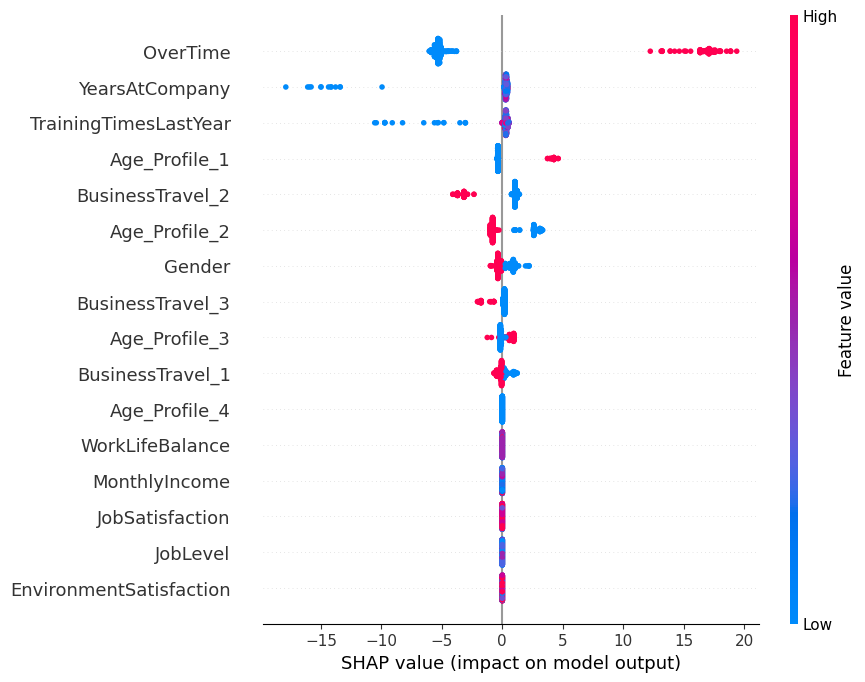

In [34]:
explainer1 = shap.Explainer(model, X_test)
shap_values = explainer1(X_test)

shap.plots.beeswarm(shap_values, max_display=17, order=shap_values.abs.max(0))

### Waterfall

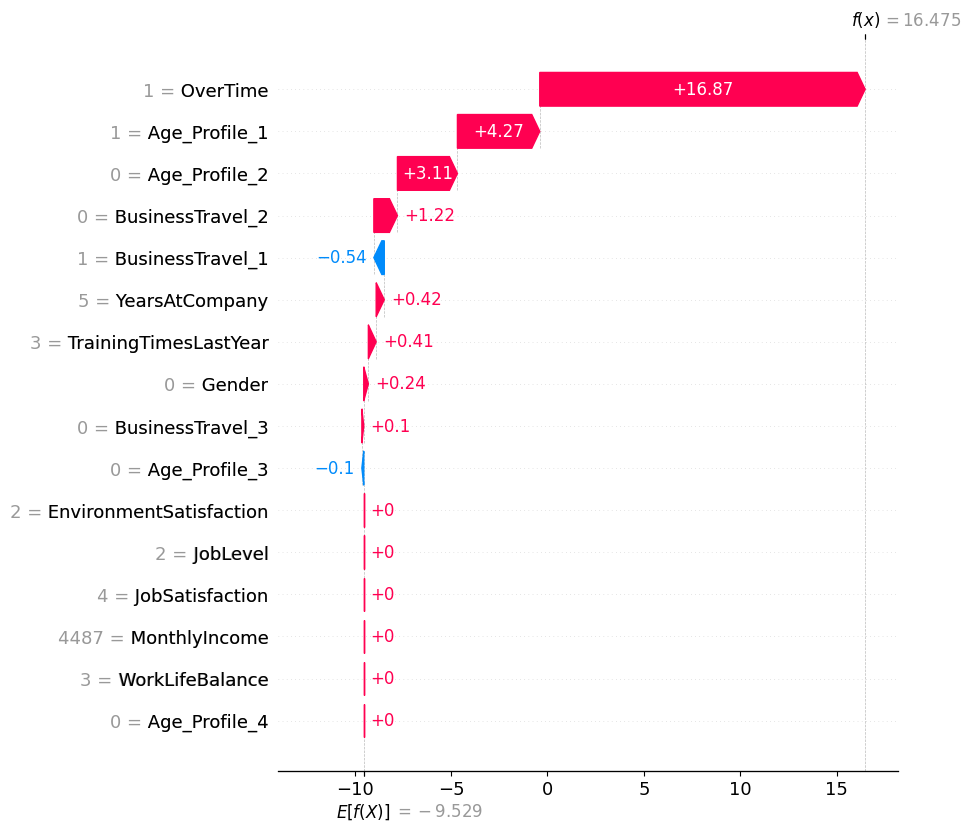

In [35]:
shap.plots.waterfall(shap_values[0], max_display=17)